In [4]:
import matplotlib.pyplot as mp

import cartopy
import numpy
import xarray
import pandas
import netCDF4
import scipy.stats
import cmocean

mp.rcParams.update({'mathtext.default': 'regular'})

In [5]:
!ls /beegfs/DATA/pritchard/blangenb/CRU_DATA/

cru_ts4.01.1901.2016.pre.dat.nc  cru_ts4.01.1901.2016.tmp.dat.nc
cru_ts4.01.1901.2016.tmn.dat.nc  cru_ts4.01.1901.2016.tmx.dat.nc


In [6]:
tmp_filename = '/beegfs/DATA/pritchard/blangenb/CRU_DATA/cru_ts4.01.1901.2016.tmp.dat.nc'

ds_tmp = xarray.open_dataset(tmp_filename, decode_times=False)

tmp_time_var = ds_tmp['time']
tmp_datetime = netCDF4.num2date(tmp_time_var.values, \
                                tmp_time_var.units, \
                                calendar='standard')

tmp_time = tmp_time_var.values
tmp_data = ds_tmp['tmp'].values
tmp_lon = ds_tmp['lon'].values
tmp_lat = ds_tmp['lat'].values

In [7]:
tmp_time_mean = numpy.nanmean(tmp_data, axis=0)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/export/home/blangenb/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


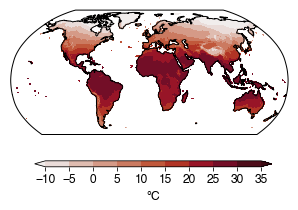

In [8]:
fontsize = 12

map_proj = cartopy.crs.Robinson()
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(4.25,2.5))

ax = fig.add_subplot(111, projection=map_proj)

levels = numpy.arange(-10,35.1,5)
contour_plot = ax.contourf(tmp_lon, tmp_lat, \
                           tmp_time_mean, \
                           levels=levels, \
                           cmap = cmocean.cm.amp, \
                           transform=data_proj, \
                           extend='both')

ax.coastlines()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0,axpos.y0-0.15,axpos.width,0.0333])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')

cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\degree$C', fontsize=fontsize)

fig.tight_layout()

# Cropping tools

clipping raster data to geographical boundaries

Taken from Stephan Hoyer's documentation here:  https://github.com/pydata/xarray/issues/501#issuecomment-126461466

Also borrowed info from the cartoy add_geometries doc here:
https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html

In [9]:
# function definitions from Stephan Hoyer
import geopandas
from rasterio import features
from affine import Affine

# takes a lat/lon values in a data array and
# transforms them into the new coord system
def transform_from_latlon(lat, lon):
    lat = numpy.asarray(lat)
    lon = numpy.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

# takes the transformed stuff and rasterizes it
def rasterize(shapes, coords, fill=numpy.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d lat and lon
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xarray.DataArray(raster, coords=coords, dims=('lat', 'lon'))

## this shapefile is from natural earth data
## http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
# states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
# states.head()

Read in country shape file using geopandas  
download data from Natural Earth:  https://www.naturalearthdata.com/

In [10]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')

In [19]:
states.columns

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local',
       'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe',
       'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me',
       'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank',
       'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id',
       'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3',
       'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name',
       'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code',
       'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1',
       'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid',
       'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr',
       'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja',
       'name_ko', 'name_nl', 'name_pl', 'name_

In [21]:
states_indo = states[states['admin']=='Indonesia']

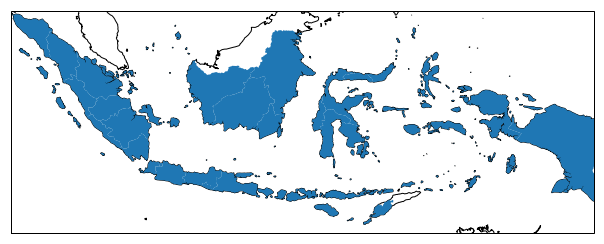

In [32]:
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8.5,5))

ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(resolution='10m')
ax.add_geometries(states_indo.geometry, crs=map_proj)

minx_min = numpy.min(states_indo.geometry.bounds['minx'])
maxx_max = numpy.max(states_indo.geometry.bounds['maxx'])
miny_min = numpy.min(states_indo.geometry.bounds['miny'])
maxy_max = numpy.max(states_indo.geometry.bounds['maxy'])

ax.set_extent([minx_min,maxx_max,miny_min,maxy_max])

fig.tight_layout()

In [35]:
states_indo.columns

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt', 'name_local',
       'type', 'type_en', 'code_local', 'code_hasc', 'note', 'hasc_maybe',
       'region', 'region_cod', 'provnum_ne', 'gadm_level', 'check_me',
       'datarank', 'abbrev', 'postal', 'area_sqkm', 'sameascity', 'labelrank',
       'name_len', 'mapcolor9', 'mapcolor13', 'fips', 'fips_alt', 'woe_id',
       'woe_label', 'woe_name', 'latitude', 'longitude', 'sov_a3', 'adm0_a3',
       'adm0_label', 'admin', 'geonunit', 'gu_a3', 'gn_id', 'gn_name',
       'gns_id', 'gns_name', 'gn_level', 'gn_region', 'gn_a1_code',
       'region_sub', 'sub_code', 'gns_level', 'gns_lang', 'gns_adm1',
       'gns_region', 'min_label', 'max_label', 'min_zoom', 'wikidataid',
       'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es', 'name_fr',
       'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it', 'name_ja',
       'name_ko', 'name_nl', 'name_pl', 'name_

In [50]:
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]
states_indo_kalimantan.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,geometry
4,Admin-1 scale rank,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,Oost-Kalimantan,Borneo Wschodnie,Kalimantan Oriental,Восточный Калимантан,Kalimantan Timur,Doğu Kalimantan,Đông Kalimantan,東加里曼丹省,1159310009,(POLYGON ((117.7036079039552 4.163414542001791...
629,Admin-1 scale rank,2,IDN-1228,1228,ID-KB,None,ID,5,Kalimantan Barat,Kalbar,...,West-Kalimantan,Borneo Zachodnie,Kalimantan Ocidental,Западный Калимантан,Kalimantan Barat,Batı Kalimantan,Tây Kalimantan,西加里曼丹省,1159309929,"(POLYGON ((109.645274285 2.083238023000092, 10..."
1828,Admin-1 scale rank,2,IDN-1931,1931,ID-KT,None,ID,1,Kalimantan Tengah,Kalteng,...,Midden-Kalimantan,Borneo Środkowe,Kalimantan Central,Центральный Калимантан,Kalimantan Tengah,Orta Kalimantan,Trung Kalimantan,中加里曼丹省,1159311333,"POLYGON ((114.3106832661966 -3.43391382655977,..."
1829,Admin-1 scale rank,2,IDN-1234,1234,ID-KS,None,ID,5,Kalimantan Selatan,Kalsel,...,Zuid-Kalimantan,Borneo Południowe,Kalimantan do Sul,Южный Калимантан,Kalimantan Selatan,Güney Kalimantan,Nam Kalimantan,南加里曼丹省,1159309697,"(POLYGON ((116.572890168788 -2.36297628779497,..."


In [93]:
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

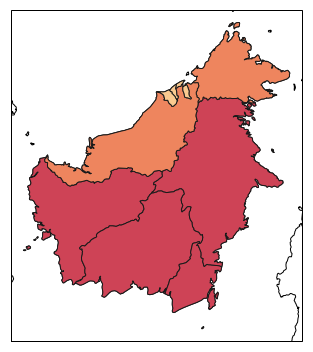

In [96]:
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8.5,5))

ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(resolution='10m')

ax.add_geometries(states_indo_kalimantan.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.5), edgecolor='0.1')
ax.add_geometries(states_malay_borneo.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.3), edgecolor='0.1')
ax.add_geometries(states_brunei.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.1), edgecolor='0.1')

minx_min = numpy.min(states_indo_kalimantan.geometry.bounds['minx'])
maxx_max = numpy.max(states_malay_borneo.geometry.bounds['maxx'])
miny_min = numpy.min(states_indo_kalimantan.geometry.bounds['miny'])
maxy_max = numpy.max(states_malay_borneo.geometry.bounds['maxy'])

offset = 0.5
ax.set_extent([minx_min-offset,maxx_max+offset,miny_min-offset,maxy_max+offset])

fig.tight_layout()

In [97]:
all_concat = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])

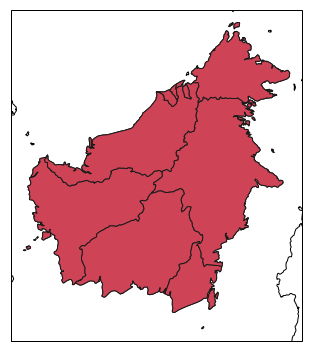

In [98]:
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8.5,5))

ax = fig.add_subplot(111, projection=map_proj)
ax.coastlines(resolution='10m')

ax.add_geometries(all_concat.geometry, crs=map_proj, facecolor=cmocean.cm.matter(0.5), edgecolor='0.1')

minx_min = numpy.min(all_concat.geometry.bounds['minx'])
maxx_max = numpy.max(all_concat.geometry.bounds['maxx'])
miny_min = numpy.min(all_concat.geometry.bounds['miny'])
maxy_max = numpy.max(all_concat.geometry.bounds['maxy'])

offset = 0.5
ax.set_extent([minx_min-offset,maxx_max+offset,miny_min-offset,maxy_max+offset])

fig.tight_layout()